# Initialize

## Import Modules & Set Options

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import swifter
from collections import namedtuple
import matplotlib.pyplot as plt
from pprint import pprint

pd.set_option('display.max_columns', 200)
# pd.set_option('display.max_rows', 200)

## Define myQueue

In [2]:
class myQueue:
    def __init__(self, maxsize=0):
        self.data = []
        self.maxsize = maxsize if maxsize > 0 else float('inf')
    def tolist(self):
        return self.data
    def size(self):
        return self.maxsize
    def len(self):
        return len(self.data)
    def empty(self):
        return self.len() == 0
    def full(self):
        return self.len() == self.maxsize
    def pop(self, index=0):
        """
        if index > 0, recursively pop() until pop out the specific element.
        return the final popped-out element.
        """
        for _ in range(index, 0, -1):
            self.pop()
        return self.data.pop(0) if not self.empty() else None
    def push(self, element):
        """
        return 0 if success; 1 if the front is popped.
        """
        flag = 0
        if self.full():
            self.pop()
            flag = 1
        self.data.append(element)
        return flag
    def front(self):
        return self.data[0] if not self.empty() else None
    def rear(self):
        return self.data[-1] if not self.empty() else None
    def get(self, index):
        if isinstance(index, list):
            tmp = []
            for i in index:
                tmp = [*tmp, self.get(i)]
            return tmp
        return self.data[index] if index < self.len() and abs(index) <= self.len() else None
    def find(self, element):
        if isinstance(element, list):
            for ele in element:
                index = self.find(ele)
                if index != None:
                    return index
            return None
        return self.data.index(element) if element in self.data else None

## Define mi_parse_ho

In [5]:
def mi_parse_ho(df, tz=0, debug=False):
    df['Timestamp'] = pd.to_datetime(df['Timestamp']) + pd.Timedelta(hours=tz)
    
    ### Define Basic Element
    HO = namedtuple('HO', 'start, end, cause, others', defaults=tuple([None]*4))
    stNR = namedtuple('stNR', 'snrPCI, tnrPCI', defaults=tuple([None]*2))
    stLTE = namedtuple('stLTE', 'sPCI, sFreq, tPCI, tFreq', defaults=tuple([None]*4))
    NR_CEL = namedtuple('NR_CEL', 'nrPCI, nrFreq', defaults=tuple([None]*2))
    LTE_CEL = namedtuple('LTE_CEL', 'ePCI, ECI, eNB, BID, DL_Freq, DL_BW, UL_Freq, UL_BW', defaults=tuple([None]*8))
    C = namedtuple('C', HO._fields + stLTE._fields + stNR._fields + \
        LTE_CEL._fields + tuple([f'{s}1' for s in LTE_CEL._fields]) + NR_CEL._fields + tuple([f'{s}1' for s in NR_CEL._fields]), 
        defaults=tuple([None]*30))
    
    def dprint(*args, **kwargs):
        if debug:
            print(*args, **kwargs)
    
    def NR_OTA(pos=None):
        row = df.iloc[pos] if pos else df.iloc[i]
        if row.type_id == '5G_NR_RRC_OTA_Packet':
            return True
        else:
            return False
    
    def CEL_INFO(pos=None):
        row = df.iloc[pos] if pos else df.iloc[i]
        if row.type_id == 'LTE_RRC_Serv_Cell_Info':
            return True
        else:
            return False
    
    def nr_track(pos=None):
        row = df.iloc[pos] if pos else df.iloc[i]
        if int(row.PCI) in [0, 65535]:  # 65535 is for samgsung; 0 is for xiaomi.
            return NR_CEL()
        else:
            return NR_CEL(int(row.PCI), int(row.Freq))
    
    def eci_track(pos=None):
        row = df.iloc[pos] if pos else df.iloc[i]
        PCI = int(row['PCI'])
        ECI = int(row['Cell Identity'])
        eNB = ECI // 256
        BID = int(row['Band ID'])
        DL_Freq = int(row['DL frequency'])
        DL_BW = row['DL bandwidth']
        UL_Freq = int(row['UL frequency'])
        UL_BW = row['UL bandwidth']
        return LTE_CEL(PCI, ECI, eNB, BID, DL_Freq, DL_BW, UL_Freq, UL_BW)
    
    def peek_nr(pos=None, look_after=0.5, look_before=0.0):
        ## look_after == 0.5 is a magic number
        ### TODO 先偷看 ho start - end 之間的 cell information
        if pos:  # position of end of an event
            for j in range(i, pos):
                if NR_OTA(j):
                    qpscell.push(nr_track(j))
        ### END TODO
        # dprint(f'pscell={pscell}')
        # dprint(qpscell.tolist())
        index = None
        for j in range(qpscell.len()):
            if pscell != qpscell.get(j):
                index = j
                break
        # dprint(f'index={index}')
        if index != None:
            return qpscell.pop(index)
        ### haven't find pci change yet!
        t = df['Timestamp'].iloc[i]
        for j in range(i, len(df)):  # 往前走，最多走到底
            t1 = df["Timestamp"].iloc[j]
            if (t1 - t).total_seconds() > look_after:
                break
            if df['type_id'].iloc[j] != '5G_NR_RRC_OTA_Packet':
                continue
            row = df.iloc[j]
            if int(row.PCI) in [0, 65535]:  # 65535 is for samgsung; 0 is for xiaomi.
                return NR_CEL()
            else:
                return NR_CEL(int(row.PCI), int(row.Freq))
        return pscell
    
    def peek_eci(pos=None, look_after=0.5, look_before=0.0):
        ## look_after == 0.5 is a magic number
        ### TODO 先偷看 ho start - end 之間的 cell information
        if pos:  # position of end of an event
            for j in range(i, pos):
                if CEL_INFO(j):
                    qpcell.push(eci_track(j))
        ### END TODO
        # dprint(f'pcell={pcell}')
        # dprint(qpcell.tolist())
        index = None
        for j in range(qpcell.len()):
            if pcell != qpcell.get(j):
                index = j
                break
        # dprint(f'index={index}')
        if index != None:
            return qpcell.pop(index)
        ### haven't find pci change yet!
        t = df['Timestamp'].iloc[i]
        for j in range(i, len(df)):  # 往前走，最多走到底
            t1 = df['Timestamp'].iloc[j]
            if (t1 - t).total_seconds() > look_after:
                break
            if df['type_id'].iloc[j] != 'LTE_RRC_Serv_Cell_Info':
                continue
            row = df.iloc[j]
            PCI = int(row['PCI'])
            ECI = int(row['Cell Identity'])
            eNB = ECI // 256
            BID = int(row['Band ID'])
            DL_Freq = int(row['DL frequency'])
            DL_BW = row['DL bandwidth']
            UL_Freq = int(row['UL frequency'])
            UL_BW = row['UL bandwidth']
            return LTE_CEL(PCI, ECI, eNB, BID, DL_Freq, DL_BW, UL_Freq, UL_BW)
        return pcell

    def find_1st_after(target, look_after=1.0):
        for j in range(i, len(df)):  # 往前走，最多走到底
            t1 = df["Timestamp"].iloc[j]
            if (t1 - t).total_seconds() > look_after:
                return None, None
            if df[target].iloc[j] in [1,'1']:
                return t1, j  # timestamp & position
        return None, None

    def find_1st_before(target, look_before=1.0):
        for j in range(i, -1, -1):  # 倒退嚕，最多走回頭
            t1 = df["Timestamp"].iloc[j]
            if (t - t1).total_seconds() > look_before:
                return None, None
            if df[target].iloc[j] in [1,'1']:
                return t1, j  # timestamp & position
        return None, None

    D = {
        ### Conn Setup/Rel & HO
        'Conn_Rel':[],    # Conn Release: rrcConnectionRelease
        'Conn_Setup':[],  # Conn Setup: rrcConnectionRequest + rrcConnectionSetup
        'LTE_HO': [],     # E_PCel -> E_PCel’: lte-rrc.t304 & LTE_PCel does change
        'SN_Rel': [],     # EUTRA + NR -> EUTRA:(CHT) lte-rrc.t304 & LTE_PCel does not change
                          #                     (TWM) nr-Config-r15: release (0) 
        'SN_Setup': [],   # EUTRA -> EUTRA + NR:(CHT) lte-rrc.t304 + nr-rrc.t304 + dualConnectivityPHR: setup (1) & LTE_PCel does not change
                          #                     (TWM) nr-rrc.t304 + dualConnectivityPHR: setup (1)
        'MN_HO': [],      # E_PCel + N_PSCel -> E_PCel’ + N_PSCel: lte-rrc.t304 + nr-rrc.t304 + dualConnectivityPHR: setup (1) & LTE_PCel does change
        'SN_HO': [],      # E_PCel + N_PSCel -> E_PCel + N_PSCel’: nr-rrc.t304
        'MNSN_HO': [],         # (TWM)
        'SN_Rel_MN_HO': [],    # (TWM)
        'SN_Setup_MN_HO': [],  # (TWM)
        ### Link Failure
        'SCG_Failure': [],   # scgFailureInformationNR-r15
        'MCG_Failure': [],   # rrcConnectionReestablishmentRequest + rrcConnectionReestablishmentComplete
        'NAS_Recovery': [],  # rrcConnectionReestablishmentRequest + rrcConnectionReestablishmentReject + rrcConnectionRequest + rrcConnectionSetup
        # MCG_Failure, NAS_Recovery may be caused by 'reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)'
        }
    
    A = { 'Conn_Rel':[], 'Conn_Setup':[],
        'LTE_HO': [], 'SN_Rel': [], 'SN_Setup': [], 'MN_HO': [], 'SN_HO': [],
        'MNSN_HO': [], 'SN_Rel_MN_HO': [], 'SN_Setup_MN_HO': [],
        'SCG_Failure': [], 'MCG_Failure': [], 'NAS_Recovery': [] }
    
    qpscell = myQueue(3)
    qpcell = myQueue(3)
    
    init = 1
    pcell, pscell = LTE_CEL(), NR_CEL()
    prev_pci, prev_freq = None, None
    
    for i, row in df.iterrows():
        if NR_OTA():
            qpscell.push(nr_track())
            continue
        elif CEL_INFO():
            qpcell.push(eci_track())
            continue
        if init:
            t_init, pci_init, freq_init = row.Timestamp, int(row.PCI), int(row.Freq)
            pcell = LTE_CEL(ePCI=pci_init, DL_Freq=freq_init)
            dprint(f"{t_init} | Initial PCI={pci_init} EARFCN={freq_init}")
            dprint()
            init = 0
        
        t, pci, freq = row.Timestamp, int(row.PCI), int(row.Freq)
        
        if (prev_pci, prev_freq) != (pci, freq):
            for j in range(i, len(df)):  # 往前走，最多走到底
                if CEL_INFO(j):
                    next_pcell = eci_track(j)
                    if next_pcell[0] == pci:
                        qpcell.push(next_pcell)
                        break
                elif not NR_OTA(j):
                    if df['PCI'].iloc[j] != pci:
                        break
        
        if not qpscell.empty():
            pscell = qpscell.pop()
        if not qpcell.empty():
            pcell = qpcell.pop()
        
        ### Conn_Rel
        if df["rrcConnectionRelease"].iloc[i] == 1:
            D['Conn_Rel'].append(HO(start=t))
            A['Conn_Rel'].append(C(*HO(start=t), *stLTE(sPCI=pci, sFreq=freq), *stNR(snrPCI=pscell[0]), *pcell, *LTE_CEL(), *pscell, *NR_CEL()))
            dprint(f"{t}, {pd.NaT} | Conn_Rel at PCI={pci} EARFCN={freq}.")
            dprint(f'{tuple(pcell)} -> {tuple(LTE_CEL())}')
            dprint(f'{tuple(pscell)} ->{tuple(NR_CEL())}')
            pcell, pscell = LTE_CEL(), NR_CEL()
            dprint()

        ### Conn_Setup
        if df["rrcConnectionRequest"].iloc[i] == 1:
            a, j1 = find_1st_after('rrcConnectionReconfigurationComplete',look_after=2)
            b, j2 = find_1st_after('securityModeComplete',look_after=2)
            end = a if a > b else b
            j = j1 if a > b else j2
            _pcell = peek_eci(pos=j)
            D['Conn_Setup'].append(HO(start=t, end=end))
            A['Conn_Setup'].append(C(*HO(start=t, end=end), *stLTE(tPCI=pci, tFreq=freq), *stNR(), *pcell, *_pcell, *pscell, *pscell))
            dprint(f"{t}, {end} | Conn_Setup to PCI={pci} EARFCN={freq}.")
            dprint(f'{tuple(pcell)} -> {tuple(_pcell)}')
            dprint(f'{tuple(pscell)} -> {tuple(pscell)}')
            dprint()
        
        ### SN_Setup, SN_Rel, MO_HO, LTE_HO
        if df["lte-rrc.t304"].iloc[i] == 1:
            end, j = find_1st_after('rrcConnectionReconfigurationComplete')
            serv_cell, target_cell = pci, int(df['lte_targetPhysCellId'].iloc[i])
            serv_freq, target_freq = freq, int(df['dl-CarrierFreq'].iloc[i])
            nr_target_cell = int(df["nr_physCellId"].iloc[i])
            
            if df["SCellToAddMod-r10"].iloc[i] == 1:
                n =len(str(df["SCellIndex-r10.1"].iloc[i]).split('@'))
                others=f'Set up {n} SCell.'
            else:
                others=None
            
            if serv_freq != target_freq:
                others = f'{others} Inter-Freq HO.' if others else 'Inter-Freq HO.'
            
            ### SN_Setup, MN_HO
            if df["nr-rrc.t304"].iloc[i] == 1 and df["dualConnectivityPHR: setup (1)"].iloc[i] == 1:
                ### SN_Setup
                if serv_cell == target_cell and serv_freq == target_freq:
                    _pscell = peek_nr(pos=j)
                    D['SN_Setup'].append(HO(start=t, end=end, others=others))
                    A['SN_Setup'].append(C(*HO(start=t, end=end, others=others), *stLTE(sPCI=serv_cell, sFreq=serv_freq), *stNR(tnrPCI=nr_target_cell), *pcell, *pcell, *pscell, *_pscell))
                    dprint(f"{t}, {end} | SN_Setup to nrPCI={nr_target_cell} | {others}")
                    dprint(f'{tuple(pcell)} -> {tuple(pcell)}')
                    dprint(f'{tuple(pscell)} -> {tuple(_pscell)}')
                    dprint()
                else:
                ### MN_HO
                    _pcell = peek_eci(pos=j)
                    D['MN_HO'].append(HO(start=t, end=end, others=others))
                    A['MN_HO'].append(C(*HO(start=t, end=end, others=others), *stLTE(sPCI=serv_cell, sFreq=serv_freq, tPCI=target_cell, tFreq=target_freq), *stNR(snrPCI=pscell[0]), *pcell, *_pcell, *pscell, *pscell))
                    dprint(f"{t}, {end} | MN_HO ({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | {others}")
                    dprint(f'{tuple(pcell)} -> {tuple(_pcell)}')
                    dprint(f'{tuple(pscell)} -> {tuple(pscell)}')
                    dprint()
            else:
            ### SN_Rel, LTE_HO
                ### SN_Rel
                if serv_cell == target_cell and serv_freq == target_freq:
                    a, b = find_1st_before("scgFailureInformationNR-r15")
                    if a is not None:
                        others = f'{others} Caused by scg-failure.' if others else 'Caused by scg-failure.'
                    D['SN_Rel'].append(HO(start=t, end=end, others=others))
                    A['SN_Rel'].append(C(*HO(start=t, end=end, others=others), *stLTE(sPCI=serv_cell, sFreq=serv_freq), *stNR(snrPCI=pscell[0]), *pcell, *pcell, *pscell, *NR_CEL()))
                    dprint(f"{t}, {end} | SN_Rel at nrPCI={pscell[0]} | {others}")
                    dprint(f'{tuple(pcell)} -> {tuple(pcell)}')
                    dprint(f'{tuple(pscell)} -> {tuple(NR_CEL())}')
                    pscell = NR_CEL()
                    dprint()
                else:
                ### LTE_HO
                    _pcell = peek_eci(pos=j)
                    D['LTE_HO'].append(HO(start=t, end=end, others=others))
                    A['LTE_HO'].append(C(*HO(start=t, end=end, others=others), *stLTE(sPCI=serv_cell, sFreq=serv_freq, tPCI=target_cell, tFreq=target_freq), *stNR(), *pcell, *_pcell, *pscell, *pscell))
                    dprint(f"{t}, {end} | LTE_HO ({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | {others}")
                    dprint(f'{tuple(pcell)} -> {tuple(_pcell)}')
                    dprint(f'{tuple(pscell)} -> {tuple(pscell)}')
                    dprint()

        ### SN_HO
        if df["nr-rrc.t304"].iloc[i] == 1 and not df["dualConnectivityPHR: setup (1)"].iloc[i] == 1:
            end, j = find_1st_after('rrcConnectionReconfigurationComplete')
            nr_target_cell = int(df["nr_physCellId"].iloc[i])
            _pscell = peek_nr(pos=j)
            D['SN_HO'].append(HO(start=t, end=end))
            A['SN_HO'].append(C(*HO(start=t, end=end), *stLTE(sPCI=pci, sFreq=freq), *stNR(snrPCI=pscell[0], tnrPCI=nr_target_cell), *pcell, *pcell, *pscell, *_pscell))
            dprint(f"{t}, {end} | SN_HO to nrPCI={nr_target_cell}")
            dprint(f'{tuple(pcell)} -> {tuple(pcell)}')
            dprint(f'{tuple(pscell)} -> {tuple(_pscell)}')
            dprint()

        ### SCG_Failure
        if df["scgFailureInformationNR-r15"].iloc[i] == 1:
            # others = df["failureType-r15"].iloc[i]
            cause = df["failureType-r15"].iloc[i]
            _pscell = peek_nr()
            D['SCG_Failure'].append(HO(start=t, cause=cause))  # end time??
            A['SCG_Failure'].append(C(*HO(start=t, cause=cause), *stLTE(sPCI=pci, sFreq=freq), *stNR(snrPCI=pscell[0]), *pcell, *pcell, *pscell, *_pscell))
            dprint(f"{t}, {pd.NaT} | SCG_Failure at nrPCI={pscell[0]} | {cause}")
            dprint(f'{tuple(pcell)} -> {tuple(pcell)}')
            dprint(f'{tuple(pscell)} -> {tuple(_pscell)}')
            ### SCG Fail 之後必定會 SN Rel
            dprint()
        
        ### MCG_Failure (type II), NAS_Recovery (type III)
        if df["rrcConnectionReestablishmentRequest"].iloc[i] == 1:
            end1, j1 = find_1st_after('rrcConnectionReestablishmentComplete', look_after=1)
            end2, j2 = find_1st_after('rrcConnectionReestablishmentReject', look_after=1)
            end3, j3 = find_1st_after('rrcConnectionRequest', look_after=1)
            # others = df["reestablishmentCause"].iloc[i]
            cause = df["reestablishmentCause"].iloc[i]
            # target_cell = int(df['physCellId.3'].iloc[i])
            serv_cell, target_cell = pci, int(df['physCellId.3'].iloc[i])
            serv_freq, target_freq = freq, None
            
            ### MCG_Failure (type II)
            if (end1 and not end2) or (end1 and end2 and end1 < end2):
                # dprint(end1, end2)
                end, j = end1, j1
                _pcell = peek_eci()
                D['MCG_Failure'].append(HO(start=t, end=end, cause=cause))
                A['MCG_Failure'].append(C(*HO(start=t, end=end, cause=cause), *stLTE(sPCI=serv_cell, sFreq=serv_freq, tPCI=target_cell, tFreq=target_freq), *stNR(snrPCI=pscell[0]), *pcell, *_pcell, *pscell, *NR_CEL()))
                dprint(f"{t}, {end} | MCG_Failure PCI={serv_cell} -> PCI={target_cell}, recconected to {pci} | {cause}")
                dprint(f'{tuple(pcell)} -> {tuple(_pcell)}')
                dprint(f'{tuple(pscell)} -> {tuple(NR_CEL())}')
                pscell = NR_CEL()
                dprint()
                ### MCG Fail 之後有機會不經過 RRC Connection Setup 就 Reconnect
            else: 
            ### NAS_Recovery (type III)
                # dprint(end1, end2)
                end, j = end3, j3
                _pcell = peek_eci()
                D['NAS_Recovery'].append(HO(start=t, end=end-pd.Timedelta(microseconds=1) if end else None, cause=cause))  # end time??
                A['NAS_Recovery'].append(C(*HO(start=t, end=end-pd.Timedelta(microseconds=1) if end else None, cause=cause), *stLTE(sPCI=serv_cell, sFreq=serv_freq, tPCI=target_cell, tFreq=target_freq), *stNR(snrPCI=pscell[0]), *pcell, *_pcell, *pscell, *NR_CEL()))
                dprint(f"{t}, {end} | NAS_Recovery PCI={serv_cell} -> PCI={target_cell} | {cause}")
                dprint(f'{tuple(pcell)} -> {tuple(_pcell)}')
                dprint(f'{tuple(pscell)} -> {tuple(NR_CEL())}')
                pscell = NR_CEL()
                dprint()
        
        ### Update previous pci, freq
        prev_pci, prev_freq = pci, freq
    
    ### Build DataFrame
    df_HO = pd.DataFrame()
    for key in A.keys():
        df_HO = pd.concat([df_HO, \
            pd.DataFrame(A[key], index=[key]*len(A[key]))])
    if df_HO.empty:
        print("************** Empty DataFrame!! **************")
    df_HO = df_HO.sort_values(by=['start']).reset_index()
    df_HO = df_HO.rename(columns={'index': 'ho_type'})
    df_HO = df_HO.reindex(
        ['start','end','ho_type','interrupt','sPCI','sFreq','tPCI','tFreq','snrPCI','tnrPCI','cause','others'] + \
            df_HO.columns.tolist()[df_HO.columns.get_loc('ePCI'):df_HO.columns.get_loc('nrFreq1')+1], axis=1)
    df_HO['start'] = pd.to_datetime(df_HO['start'])
    df_HO['end'] = pd.to_datetime(df_HO['end'])
    df_HO['Timestamp'] = df_HO['start']
    df_HO['Type_ID'] = 'RRC_OTA_Handover_Parsing'
    df_HO['interrupt'] = (df_HO['end'] - df_HO['start']).dt.total_seconds()
    ### Set dtypes
    df_HO['ho_type'] = df_HO['ho_type'].astype('category')
    df_HO['cause'] = df_HO['cause'].astype('category')
    df_HO['others'] = df_HO['others'].astype('string')
    df_HO['DL_BW'] = df_HO['DL_BW'].astype('category')
    df_HO['DL_BW1'] = df_HO['DL_BW1'].astype('category')
    df_HO['UL_BW'] = df_HO['UL_BW'].astype('category')
    df_HO['UL_BW1'] = df_HO['UL_BW1'].astype('category')
    for tag in df_HO.columns[df_HO.columns.get_loc('sPCI'):df_HO.columns.get_loc('nrFreq1')+1]:
        if tag not in ['cause','others','DL_BW','DL_BW1','UL_BW','UL_BW1']:
            df_HO[tag] = df_HO[tag].astype('Int32')
    df_HO['interrupt'] = df_HO['interrupt'].astype('float32')
    df_HO['Timestamp'] = pd.to_datetime(df_HO['Timestamp'])
    df_HO['Type_ID'] = df_HO['Type_ID'].astype('category')
    return A, D, df_HO

## Define mi_parse_cell

In [22]:
def nr_serving_cell(row):
    pos = row.Serv_Cell_Pos
    if pos == 255:
        return None, None, None
    else:
        return row[f'PCI{pos}'], row[f'RSRP{pos}'], row[f'RSRQ{pos}']

def mi_parse_cell(df, rat='lte'):
    ### LTE
    if rat == 'lte':
        df = df.rename(columns={
            'type_id': 'Type_ID',
            'RSRP(dBm)': 'RSRP',
            'RSRQ(dB)': 'RSRQ',
            'Serving Cell Index': 'Serv_Cell_Index',
            'Number of Neighbor Cells': 'Num_Neigh_Cells',
            'Number of Detected Cells': 'Num_Cells',
        })
        df = df.reindex(['Timestamp', 'Type_ID', 'PCI', 'RSRP', 'RSRQ', 'Serv_Cell_Index', 'EARFCN', 'Raster_ARFCN',
                        'Num_Cells', 'Num_Neigh_Cells', 'Serv_Cell_Pos', 'Serv_Cell_PCI',
                        'PCI0', 'RSRP0', 'RSRQ0', *df.columns.to_list()[df.columns.get_loc('PCI1'):]], axis=1)
        df.loc[df['Serv_Cell_Index'] == '(MI)Unknown', 'Serv_Cell_Index'] = '3_SCell'
    ### NR
    if rat == 'nr':
        df = df.rename(columns={
            'type_id': 'Type_ID',
            'Raster ARFCN': 'Raster_ARFCN',
            'Serving Cell Index': 'Serv_Cell_Pos',
            'Serving Cell PCI': 'Serv_Cell_PCI',
            'Num Cells': 'Num_Cells',
        })
        df = df.reindex(['Timestamp', 'Type_ID', 'PCI', 'RSRP', 'RSRQ', 'Serv_Cell_Index', 'EARFCN', 'Raster_ARFCN',
                        'Num_Cells', 'Num_Neigh_Cells', 'Serv_Cell_Pos', 'Serv_Cell_PCI',
                        'PCI0', 'RSRP0', 'RSRQ0', *df.columns.to_list()[df.columns.get_loc('PCI1'):]], axis=1)
        df.loc[df['Serv_Cell_Pos'] != 255, 'Serv_Cell_Index'] = 'PSCell'
        df[['PCI','RSRP','RSRQ']] = df.apply(nr_serving_cell, axis=1, result_type='expand')
    ### Set dtypes
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['Type_ID'] = df['Type_ID'].astype('category')
    df['Serv_Cell_Index'] = df['Serv_Cell_Index'].astype('category')
    df['EARFCN'] = df['EARFCN'].astype('Int32')
    df['Raster_ARFCN'] = df['Raster_ARFCN'].astype('Int32')
    df['Num_Cells'] = df['Num_Cells'].astype('UInt8')
    df['Num_Neigh_Cells'] = df['Num_Neigh_Cells'].astype('UInt8')
    df['Serv_Cell_Pos'] = df['Serv_Cell_Pos'].astype('UInt8')
    df['Serv_Cell_PCI'] = df['Serv_Cell_PCI'].astype('UInt16')
    for tag in df.columns:
        if tag.startswith('PCI'):
            df[tag] = df[tag].astype('Int32')
        if tag.startswith(('RSRP','RSRQ')):
            df[tag] = df[tag].astype('float32')
    return df

## Define mi_concat

In [23]:
def mi_concat(df_LTE, df_NR, df_HO):
    df = pd.concat([df_LTE, df_NR, df_HO])
    df['Type_ID'] = df['Type_ID'].astype('category')
    df['Serv_Cell_Index'] = df['Serv_Cell_Index'].astype('category')
    df['Timestamp'] = df['Timestamp'] + pd.Timedelta(hours=8)
    df['start'] = df['start'] + pd.Timedelta(hours=8)
    df['end'] = df['end'] + pd.Timedelta(hours=8)
    df = df.sort_values(by=['Timestamp']).reset_index(drop=True)
    return df

## Define get_row

In [24]:
def get_info(row):
    NR_ML1 = '5G_NR_ML1_Searcher_Measurement_Database_Update_Ext'
    LTE_PHY = 'LTE_PHY_Connected_Mode_Intra_Freq_Meas'
    HO_PARS = 'RRC_OTA_Handover_Parsing'
    
    CellInfo = namedtuple('CellInfo', 'PCI, ARFCN, RSRP, RSRQ', defaults=tuple([None]*4))
    Cell = namedtuple('Cell', 'PCI, EARFCN, nrPCI', defaults=tuple([None]*3))
    NR_CEL = namedtuple('NR_CEL', 'nrPCI, nrFreq', defaults=tuple([None]*2))
    LTE_CEL = namedtuple('LTE_CEL', 'ePCI, ECI, eNB, BID, DL_Freq, DL_BW, UL_Freq, UL_BW', defaults=tuple([None]*8))
    
    if row.Type_ID != HO_PARS:
        row_dict = {
            'Timestamp': None,
            'RAT': None,
            'Serv_Cell_Index': None,
            'Serv_Cell': None,
            'Num_Neigh_Cells': None,
            'Neigh_Cells': [],
        }
        if row.Type_ID == LTE_PHY:
            row_dict['Timestamp'] = row.Timestamp
            row_dict['RAT'] = 'LTE'
            row_dict['Serv_Cell_Index'] = row.Serv_Cell_Index
            row_dict['Serv_Cell'] = CellInfo(int(row.PCI), int(row.EARFCN), row.RSRP, row.RSRQ)
            row_dict['Num_Neigh_Cells'] = int(row.Num_Neigh_Cells)
            for i in range(1, int(row.Num_Neigh_Cells)+1):
                row_dict['Neigh_Cells'].append(CellInfo(int(row[f'PCI{i}']), int(row.EARFCN), row[f'RSRP{i}'], row[f'RSRQ{i}']))
        elif row.Type_ID == NR_ML1:
            row_dict['Timestamp'] = row.Timestamp
            row_dict['RAT'] = 'NR'
            row_dict['Num_Neigh_Cells'] = int(row.Num_Cells)
            pos = int(row.Serv_Cell_Pos)
            if pos != 255:
                row_dict['Num_Neigh_Cells'] -= 1
                row_dict['Serv_Cell'] = CellInfo(int(row[f'PCI{pos}']), int(row.Raster_ARFCN), row[f'RSRP{pos}'], row[f'RSRQ{pos}'])
                row_dict['Serv_Cell_Index'] = row.Serv_Cell_Index
            for i in range(int(row.Num_Cells)):
                if i == pos:
                    continue
                row_dict['Neigh_Cells'].append(CellInfo(int(row[f'PCI{i}']), int(row.Raster_ARFCN), row[f'RSRP{i}'], row[f'RSRQ{i}']))
    else:
        row_dict = {
            'ho_type': row.ho_type,
            'start': row.start,
            'end': row.end,
            'interupt': row.interrupt,
            'source_cell': Cell(row.sPCI, row.sFreq, row.snrPCI),
            'target_cell': Cell(row.tPCI, row.tFreq, row.tnrPCI),
            'cause': row.cause,
            'others': row.others,
            'before_LTE': LTE_CEL(row.ePCI, row.ECI, row.eNB, row.BID, row.DL_Freq, row.DL_BW, row.UL_Freq, row.UL_BW),
            'after_LTE': LTE_CEL(row.ePCI1, row.ECI1, row.eNB1, row.BID1, row.DL_Freq1, row.DL_BW1, row.UL_Freq1, row.UL_BW1),
            'before_NR': NR_CEL(row.nrPCI, row.nrFreq),
            'after_NR': NR_CEL(row.nrPCI1, row.nrFreq1),
            'Timestamp': row.Timestamp,
        }
    return row_dict

# Testing

## Data Input

In [25]:
NR_ML1 = '5G_NR_ML1_Searcher_Measurement_Database_Update_Ext'
LTE_PHY = 'LTE_PHY_Connected_Mode_Intra_Freq_Meas'
HO_PARS = 'RRC_OTA_Handover_Parsing'

df_lte = pd.read_csv("/home/wmnlab/D/database/2023-02-04#2/_Bandlock_Udp_all_RM500Q/qc02/#02/data/diag_log_qc02_2023-02-04_17-03-23_ml1.csv")
df_nr = pd.read_csv("/home/wmnlab/D/database/2023-02-04#2/_Bandlock_Udp_all_RM500Q/qc02/#02/data/diag_log_qc02_2023-02-04_17-03-23_nr_ml1.csv")
df_ho = pd.read_csv("/home/wmnlab/D/database/2023-02-04#2/_Bandlock_Udp_all_RM500Q/qc02/#02/data/diag_log_qc02_2023-02-04_17-03-23_rrc.csv")

df_lte = mi_parse_cell(df_lte, 'lte')
df_nr = mi_parse_cell(df_nr, 'nr')
_, _, df_ho = mi_parse_ho(df_ho)
df_cell = mi_concat(df_lte, df_nr, df_ho)
df_cell.to_csv("integrated_info_example.csv", index=False)
df_cell.to_pickle("integrated_info_example.pkl")

In [28]:
# pd.set_option('display.max_rows', 200)

In [29]:
with pd.option_context('display.max_rows', None):
    print(df_cell.dtypes)

Timestamp          datetime64[ns]
Type_ID                  category
PCI                         Int32
RSRP                      float32
RSRQ                      float32
Serv_Cell_Index          category
EARFCN                      Int32
Raster_ARFCN                Int32
Num_Cells                   UInt8
Num_Neigh_Cells             UInt8
Serv_Cell_Pos               UInt8
Serv_Cell_PCI              UInt16
PCI0                        Int32
RSRP0                     float32
RSRQ0                     float32
PCI1                        Int32
RSRP1                     float32
RSRQ1                     float32
PCI2                        Int32
RSRP2                     float32
RSRQ2                     float32
PCI3                        Int32
RSRP3                     float32
RSRQ3                     float32
PCI4                        Int32
RSRP4                     float32
RSRQ4                     float32
PCI5                        Int32
RSRP5                     float32
RSRQ5         

In [9]:
# with pd.option_context('display.max_rows', None):
#     display(df_cell.query('Type_ID == @LTE_PHY').dropna(how='all', axis=1).reset_index(drop=True))
df_cell.query('Type_ID == @LTE_PHY').dropna(how='all', axis=1).reset_index(drop=True)

,Timestamp,Type_ID,PCI,RSRP,RSRQ,Serv_Cell_Index,EARFCN,Num_Cells,Num_Neigh_Cells,PCI1,RSRP1,RSRQ1,PCI2,RSRP2,RSRQ2,PCI3,RSRP3,RSRQ3,PCI4,RSRP4,RSRQ4,PCI5,RSRP5,RSRQ5,PCI6,RSRP6,RSRQ6,PCI7,RSRP7,RSRQ7,PCI8,RSRP8,RSRQ8
0,2023-02-04 17:00:47.390591,LTE_PHY_Connected_Mode_Intra_Freq_Meas,362,-85.3125,-9.3750,PCell,1750,0,2,204,-95.6250,-17.5000,422,-90.6875,-12.3125,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN
1,2023-02-04 17:00:47.393791,LTE_PHY_Connected_Mode_Intra_Freq_Meas,362,-108.0625,-17.8125,1_SCell,3050,0,3,422,-106.6875,-15.9375,174,-104.5000,-15.6875,378,-105.3125,-14.6250,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN
2,2023-02-04 17:00:48.353779,LTE_PHY_Connected_Mode_Intra_Freq_Meas,362,-106.3750,-17.1875,1_SCell,3050,0,2,174,-103.7500,-14.6875,378,-107.2500,-15.7500,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN
3,2023-02-04 17:00:48.607715,LTE_PHY_Connected_Mode_Intra_Freq_Meas,362,-85.8125,-9.5000,PCell,1750,0,2,422,-94.3125,-15.5625,204,-98.3750,-19.0000,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN
4,2023-02-04 17:00:48.793777,LTE_PHY_Connected_Mode_Intra_Freq_Meas,362,-86.3125,-9.4375,PCell,1750,0,3,370,-97.5000,-21.8125,422,-94.8125,-16.3750,204,-95.1875,-18.3125,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1933,2023-02-04 17:13:44.624290,LTE_PHY_Connected_Mode_Intra_Freq_Meas,27,-79.1250,-7.9375,PCell,1750,0,3,152,-93.4375,-21.3750,35,-92.1875,-20.5625,43,-92.0000,-20.8125,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN
1934,2023-02-04 17:13:44.627146,LTE_PHY_Connected_Mode_Intra_Freq_Meas,27,-93.8750,-18.8750,1_SCell,3050,0,3,35,-87.8750,-9.7500,43,-96.7500,-20.0625,400,-95.6250,-19.6250,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN
1935,2023-02-04 17:13:45.587143,LTE_PHY_Connected_Mode_Intra_Freq_Meas,27,-96.3125,-20.3125,1_SCell,3050,0,3,35,-85.3750,-9.6875,400,-97.3750,-19.8750,43,-98.5000,-22.1250,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN
1936,2023-02-04 17:13:45.904275,LTE_PHY_Connected_Mode_Intra_Freq_Meas,27,-76.5000,-7.5625,PCell,1750,0,3,43,-96.6875,-22.2500,35,-92.1875,-21.4375,152,-94.4375,-18.8750,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN


In [10]:
# with pd.option_context('display.max_rows', None):
#     display(df_cell.query('Type_ID == @NR_ML1').dropna(how='all', axis=1).reset_index(drop=True))
df_cell.query('Type_ID == @NR_ML1').dropna(how='all', axis=1).reset_index(drop=True)

,Timestamp,Type_ID,Serv_Cell_Index,Raster_ARFCN,Num_Cells,Serv_Cell_Pos,Serv_Cell_PCI,PCI0,RSRP0,RSRQ0,PCI1,RSRP1,RSRQ1,PCI2,RSRP2,RSRQ2,PCI3,RSRP3,RSRQ3,PCI4,RSRP4,RSRQ4,PCI5,RSRP5,RSRQ5
0,2023-02-04 17:00:47.462747,5G_NR_ML1_Searcher_Measurement_Database_Update...,PSCell,631000,4,0,422,422,-90.453003,-15.594000,350,-86.844002,-13.656,362,-97.078003,-19.211000,174,-91.046997,-15.508,<NA>,NaN,NaN,<NA>,NaN,NaN
1,2023-02-04 17:00:47.661957,5G_NR_ML1_Searcher_Measurement_Database_Update...,PSCell,631000,4,0,422,422,-89.390999,-15.367000,350,-85.570000,-13.328,362,-93.515999,-18.797001,174,-92.258003,-16.711,<NA>,NaN,NaN,<NA>,NaN,NaN
2,2023-02-04 17:00:47.941942,5G_NR_ML1_Searcher_Measurement_Database_Update...,PSCell,631000,4,0,422,422,-90.890999,-16.688000,350,-85.570000,-13.328,362,-93.515999,-18.797001,174,-92.258003,-16.711,<NA>,NaN,NaN,<NA>,NaN,NaN
3,2023-02-04 17:00:48.102731,5G_NR_ML1_Searcher_Measurement_Database_Update...,PSCell,631000,3,0,422,422,-91.741997,-17.297001,350,-85.953003,-12.672,174,-93.250000,-17.851999,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN
4,2023-02-04 17:00:48.262731,5G_NR_ML1_Searcher_Measurement_Database_Update...,PSCell,631000,3,0,422,422,-91.905998,-17.648001,350,-85.991997,-12.328,174,-94.383003,-18.773001,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3028,2023-02-04 17:13:44.560595,5G_NR_ML1_Searcher_Measurement_Database_Update...,PSCell,631000,1,0,35,35,-70.789001,-10.516000,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN
3029,2023-02-04 17:13:44.881297,5G_NR_ML1_Searcher_Measurement_Database_Update...,PSCell,631000,1,0,35,35,-71.859001,-10.516000,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN
3030,2023-02-04 17:13:45.200594,5G_NR_ML1_Searcher_Measurement_Database_Update...,PSCell,631000,1,0,35,35,-72.335999,-10.516000,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN
3031,2023-02-04 17:13:45.521311,5G_NR_ML1_Searcher_Measurement_Database_Update...,PSCell,631000,1,0,35,35,-70.828003,-10.516000,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN


In [11]:
# with pd.option_context('display.max_rows', None):
#     display(df_cell.query('Type_ID == @HO_PARS').dropna(how='all', axis=1).reset_index(drop=True))
df_cell.query('Type_ID == @HO_PARS').dropna(how='all', axis=1).reset_index(drop=True)

,Timestamp,Type_ID,start,end,ho_type,interrupt,sPCI,sFreq,tPCI,tFreq,snrPCI,tnrPCI,cause,others,ePCI,ECI,eNB,BID,DL_Freq,DL_BW,UL_Freq,UL_BW,ePCI1,ECI1,eNB1,BID1,DL_Freq1,DL_BW1,UL_Freq1,UL_BW1,nrPCI,nrFreq,nrPCI1,nrFreq1
0,2023-02-04 17:00:48.634077,RRC_OTA_Handover_Parsing,2023-02-04 17:00:48.634077,2023-02-04 17:00:48.648313,SN_HO,0.014236,362,1750,<NA>,<NA>,422,350,NaN,<NA>,362,54512407,212939,3,1750,20 MHz,19750,20 MHz,362,54512407,212939,3,1750,20 MHz,19750,20 MHz,422,631000,350,631000
1,2023-02-04 17:00:58.904008,RRC_OTA_Handover_Parsing,2023-02-04 17:00:58.904008,NaT,Conn_Rel,NaN,362,1750,<NA>,<NA>,350,<NA>,NaN,<NA>,362,54512407,212939,3,1750,20 MHz,19750,20 MHz,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,<NA>,NaN,350,631000,<NA>,<NA>
2,2023-02-04 17:01:39.608751,RRC_OTA_Handover_Parsing,2023-02-04 17:01:39.608751,2023-02-04 17:01:39.743210,Conn_Setup,0.134459,<NA>,<NA>,378,3050,<NA>,<NA>,NaN,<NA>,378,54512398,212939,7,3050,20 MHz,21050,20 MHz,378,54512398,212939,7,3050,20 MHz,21050,20 MHz,<NA>,<NA>,<NA>,<NA>
3,2023-02-04 17:01:40.020318,RRC_OTA_Handover_Parsing,2023-02-04 17:01:40.020318,2023-02-04 17:01:40.055297,SN_Setup,0.034979,378,3050,<NA>,<NA>,<NA>,350,NaN,Set up 1 SCell.,378,54512398,212939,7,3050,20 MHz,21050,20 MHz,378,54512398,212939,7,3050,20 MHz,21050,20 MHz,<NA>,<NA>,350,631000
4,2023-02-04 17:01:41.722002,RRC_OTA_Handover_Parsing,2023-02-04 17:01:41.722002,2023-02-04 17:01:41.758312,MN_HO,0.036310,378,3050,362,1750,350,<NA>,NaN,Set up 1 SCell. Inter-Freq HO.,378,54512398,212939,7,3050,20 MHz,21050,20 MHz,362,54512407,212939,3,1750,20 MHz,19750,20 MHz,350,631000,350,631000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,2023-02-04 17:12:53.845535,RRC_OTA_Handover_Parsing,2023-02-04 17:12:53.845535,2023-02-04 17:12:53.864388,LTE_HO,0.018853,186,1750,27,1750,<NA>,<NA>,NaN,Set up 2 SCell.,186,54562081,213133,3,1750,20 MHz,19750,20 MHz,27,54305805,212132,3,1750,20 MHz,19750,20 MHz,<NA>,<NA>,<NA>,<NA>
71,2023-02-04 17:12:54.072603,RRC_OTA_Handover_Parsing,2023-02-04 17:12:54.072603,2023-02-04 17:12:54.109469,SN_Setup,0.036866,27,1750,<NA>,<NA>,<NA>,186,NaN,Set up 1 SCell.,27,54305805,212132,3,1750,20 MHz,19750,20 MHz,27,54305805,212132,3,1750,20 MHz,19750,20 MHz,<NA>,<NA>,186,631000
72,2023-02-04 17:12:56.392925,RRC_OTA_Handover_Parsing,2023-02-04 17:12:56.392925,2023-02-04 17:12:56.407137,SN_HO,0.014212,27,1750,<NA>,<NA>,186,35,NaN,<NA>,27,54305805,212132,3,1750,20 MHz,19750,20 MHz,27,54305805,212132,3,1750,20 MHz,19750,20 MHz,186,631000,35,631000
73,2023-02-04 17:13:15.490814,RRC_OTA_Handover_Parsing,2023-02-04 17:13:15.490814,2023-02-04 17:13:15.509292,MN_HO,0.018478,27,1750,152,1750,35,<NA>,NaN,Set up 1 SCell.,27,54305805,212132,3,1750,20 MHz,19750,20 MHz,152,54988823,214800,3,1750,20 MHz,19750,20 MHz,35,631000,35,631000


In [12]:
pprint(get_info(df_cell.query('Type_ID == @LTE_PHY').dropna(how='all', axis=1).reset_index(drop=True).iloc[0]), sort_dicts=False)

{'Timestamp': Timestamp('2023-02-04 17:00:47.390591'),
 'RAT': 'LTE',
 'Serv_Cell_Index': 'PCell',
 'Serv_Cell': CellInfo(PCI=362, ARFCN=1750, RSRP=-85.3125, RSRQ=-9.375),
 'Num_Neigh_Cells': 2,
 'Neigh_Cells': [CellInfo(PCI=204, ARFCN=1750, RSRP=-95.625, RSRQ=-17.5),
                 CellInfo(PCI=422, ARFCN=1750, RSRP=-90.6875, RSRQ=-12.3125)]}


In [13]:
pprint(get_info(df_cell.query('Type_ID == @NR_ML1').dropna(how='all', axis=1).reset_index(drop=True).iloc[0]), sort_dicts=False)

{'Timestamp': Timestamp('2023-02-04 17:00:47.462747'),
 'RAT': 'NR',
 'Serv_Cell_Index': 'PSCell',
 'Serv_Cell': CellInfo(PCI=422, ARFCN=631000, RSRP=-90.453, RSRQ=-15.594),
 'Num_Neigh_Cells': 3,
 'Neigh_Cells': [CellInfo(PCI=350, ARFCN=631000, RSRP=-86.844, RSRQ=-13.656),
                 CellInfo(PCI=362, ARFCN=631000, RSRP=-97.078, RSRQ=-19.211),
                 CellInfo(PCI=174, ARFCN=631000, RSRP=-91.047, RSRQ=-15.508)]}


In [14]:
pprint(get_info(df_cell.query('Type_ID == @HO_PARS').dropna(how='all', axis=1).reset_index(drop=True).iloc[0]), sort_dicts=False)

{'ho_type': 'SN_HO',
 'start': Timestamp('2023-02-04 17:00:48.634077'),
 'end': Timestamp('2023-02-04 17:00:48.648313'),
 'interupt': 0.014236,
 'source_cell': Cell(PCI=362, EARFCN=1750, nrPCI=422),
 'target_cell': Cell(PCI=<NA>, EARFCN=<NA>, nrPCI=350),
 'cause': nan,
 'others': <NA>,
 'before_LTE': LTE_CEL(ePCI=362, ECI=54512407, eNB=212939, BID=3, DL_Freq=1750, DL_BW='20 MHz', UL_Freq=19750, UL_BW='20 MHz'),
 'after_LTE': LTE_CEL(ePCI=362, ECI=54512407, eNB=212939, BID=3, DL_Freq=1750, DL_BW='20 MHz', UL_Freq=19750, UL_BW='20 MHz'),
 'before_NR': NR_CEL(nrPCI=422, nrFreq=631000),
 'after_NR': NR_CEL(nrPCI=350, nrFreq=631000),
 'Timestamp': Timestamp('2023-02-04 17:00:48.634077')}


## Plot Example

In [1]:
plt.gcf().autofmt_xdate()  # for subplot
plt.style.use('ggplot')

NameError: name 'plt' is not defined

### NR (RSRP, RSRQ)

In [76]:
def nr_serving_cell(row):
    pos = row.Serv_Cell_Pos
    if pos == 255:
        return None, None, None
    else:
        return row[f'PCI{pos}'], row[f'RSRP{pos}'], row[f'RSRQ{pos}']

In [77]:
%%timeit
df = df_cell.query('Type_ID == @NR_ML1')
df.apply(nr_serving_cell, axis=1, result_type='expand')

80.4 ms ± 2.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


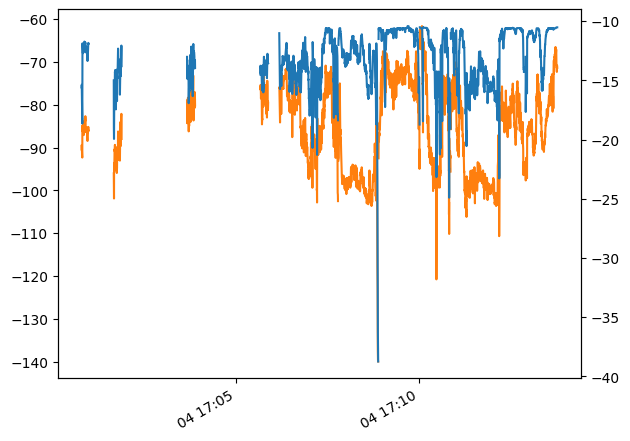

In [31]:
df = df_cell.query('Type_ID == @NR_ML1').copy()
df[['PCI','RSRP','RSRQ']] = df.apply(nr_serving_cell, axis=1, result_type='expand')
fig, ax = plt.subplots()
ax1 = ax.twinx()
# df.plot(x='Timestamp', y='RSRP', c='tab:orange', ax=ax)
# df.plot(x='Timestamp', y='RSRQ', c='tab:blue', ax=ax1)
ax.plot(df["Timestamp"].iloc[:], df["RSRP"].iloc[:], c='tab:orange', label='RSRP')
ax1.plot(df["Timestamp"].iloc[:], df["RSRQ"].iloc[:], c='tab:blue', label='RSRQ')
fig.tight_layout()
fig.autofmt_xdate()  # for figure
fig.show()

In [59]:
with pd.option_context('display.max_rows', None):
    print(df['Timestamp'].diff().dt.total_seconds())

2              NaN
3         0.199210
4         0.279985
5         0.160789
6         0.160000
8         0.320009
11        0.080112
14        0.179039
15        0.260044
16        0.159999
17        0.319997
18        0.320004
20        0.319997
23        0.320000
24        0.320000
25        0.200004
27        0.279995
30        0.320000
32        0.320000
33        0.320001
36        0.319992
37        0.160004
38        0.160796
39        0.319202
40        0.160001
42        0.160802
45        0.319195
46        0.160002
47        0.319998
48        0.160002
49        0.160793
51        0.319202
54        0.319999
56        0.320003
57        0.160001
58        0.160792
59        0.319205
63        0.159994
64        0.320005
65        0.320001
67        0.319998
70        0.319998
71        0.320000
72        0.319999
74        0.319999
75        0.159999
89       41.038706
95        0.156359
99        0.164866
103       0.240800
105       0.160007
108       0.179175
110       0.

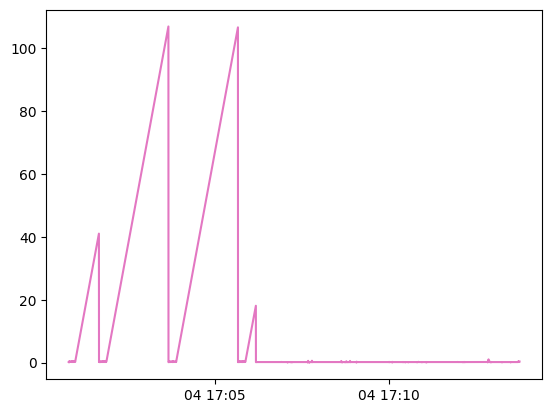

In [60]:
fig, ax = plt.subplots()
ax.plot(df["Timestamp"].iloc[:], df['Timestamp'].diff().dt.total_seconds(), c='tab:pink', label='TimeDifference')
fig.show()

### LTE (RSRP, RSRQ)

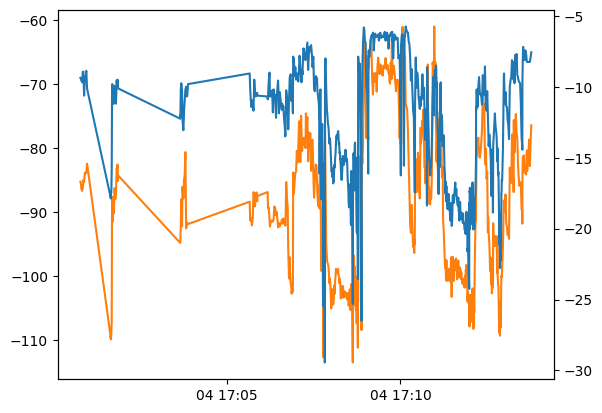

In [90]:
df = df_cell.query('Type_ID == @LTE_PHY & Serv_Cell_Index == "PCell"')
fig, ax = plt.subplots()
ax1 = ax.twinx()
# df.plot(x='Timestamp', y='RSRP', c='tab:orange', ax=ax)
# df.plot(x='Timestamp', y='RSRQ', c='tab:blue', ax=ax1)
ax.plot(df["Timestamp"].iloc[:], df["RSRP"].iloc[:], c='tab:orange', label='RSRP')
ax1.plot(df["Timestamp"].iloc[:], df["RSRQ"].iloc[:], c='tab:blue', label='RSRQ')
fig.show()

In [62]:
with pd.option_context('display.max_rows', None):
    print(df['Timestamp'].diff().dt.total_seconds())

0              NaN
9         1.217124
12        0.186062
21        1.476819
28        1.280016
34        0.983939
43        1.256031
52        1.279991
60        1.280013
62        0.023948
68        1.256042
77        1.279999
80       40.791055
85        0.114145
86        0.038657
90        0.080012
91        0.081131
96        0.088878
98        0.038926
100       0.088189
101       0.183967
104       0.093911
107       0.226064
109       0.095002
112       0.524992
115       0.101074
117       0.039986
120       0.268966
121       0.003273
124       0.047760
125       0.079999
127       0.040005
129       0.080002
132       0.357866
134       0.098937
138       0.517147
143       0.639998
146       0.343936
148       0.098920
150       0.221093
151       0.079974
153       0.053929
157       0.802150
162       0.639978
166       0.640001
171       0.639996
176       0.639999
178       0.343968
181       0.098907
184       0.517145
188       0.640002
192       0.640000
197       0.

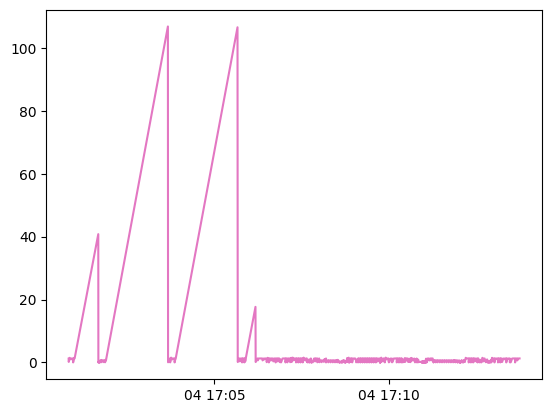

In [63]:
fig, ax = plt.subplots()
ax.plot(df["Timestamp"].iloc[:], df['Timestamp'].diff().dt.total_seconds(), c='tab:pink', label='TimeDifference')
fig.show()

### HO Timestamp

In [70]:
df = pd.read_csv("/home/wmnlab/D/database/2023-02-04#2/_Bandlock_Udp_all_RM500Q/qc02/#02/data/diag_log_qc02_2023-02-04_17-03-23_rrc.csv",
                 parse_dates=['Timestamp'])
with pd.option_context('display.max_rows', None):
    print(df['Timestamp'].diff().dt.total_seconds())

0             NaN
1        0.871085
2        0.000084
3        0.051094
4        0.001085
5        0.000013
6        0.012988
7        0.000150
8        2.903645
9        1.280012
10       2.559818
11       1.280173
12       2.232047
13       0.072299
14       3.347644
15       0.104230
16       0.000209
17       0.000003
18       0.000003
19       0.000003
20       0.012238
21       0.447536
22       0.715138
23       7.680620
24       3.839997
25       5.118022
26       1.280001
27       0.066169
28       0.000213
29       0.000003
30       0.000002
31       0.000002
32       0.012288
33       5.043281
34       2.560007
35       1.279977
36       1.280002
37       5.119997
38       2.724859
39       0.073353
40       0.004983
41       0.039969
42       0.001327
43       0.000497
44       0.014330
45       0.161977
46       0.000064
47       0.000038
48       0.037853
49       0.001959
50       0.021252
51       0.001556
52       0.046553
53       0.000047
54       0.005809
55       0

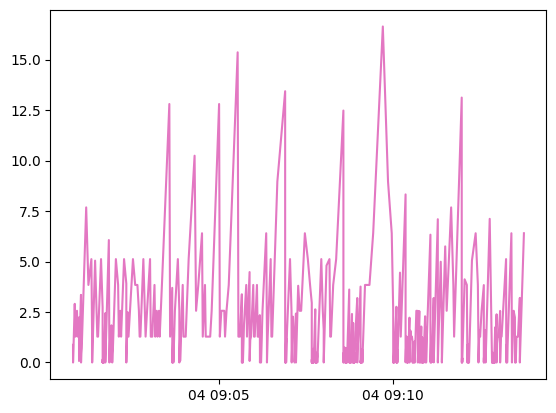

In [65]:
fig, ax = plt.subplots()
ax.plot(df["Timestamp"].iloc[:], df['Timestamp'].diff().dt.total_seconds(), c='tab:pink', label='TimeDifference')
fig.show()

In [71]:
df = pd.read_csv("/home/wmnlab/D/database/2023-02-04#2/_Bandlock_Udp_all_RM500Q/qc02/#02/data/diag_log_qc02_2023-02-04_17-03-23_rrc.csv",
                 parse_dates=['Timestamp'])
df = pd.concat([df, df_lte, df_nr]).sort_values(by=['Timestamp']).reset_index(drop=True)

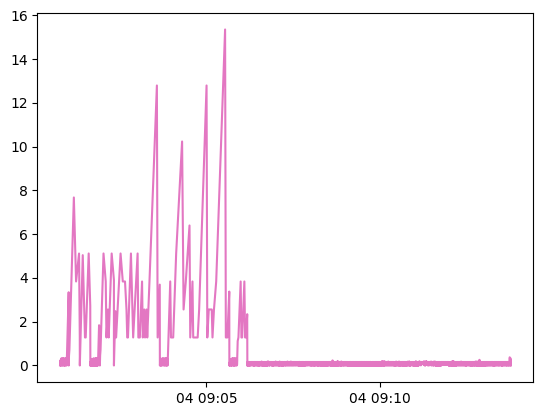

In [73]:
fig, ax = plt.subplots()
ax.plot(df["Timestamp"].iloc[:], df['Timestamp'].diff().dt.total_seconds(), c='tab:pink', label='TimeDifference')
fig.show()

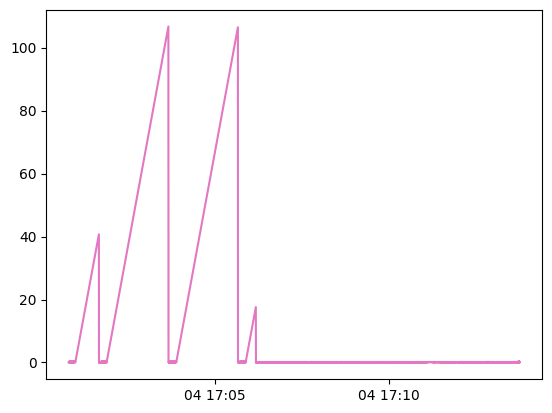

In [74]:
fig, ax = plt.subplots()
ax.plot(df_cell["Timestamp"].iloc[:], df_cell['Timestamp'].diff().dt.total_seconds(), c='tab:pink', label='TimeDifference')
fig.show()